## 总览
Spark SQL 是 Spark 处理结构化数据的一个模块, 与基础的 Spark RDD API 不同, Spark SQL 提供了查询结构化数据及计算结果等信息的接口.在内部, Spark SQL 使用这个额外的信息去执行额外的优化.有几种方式可以跟 Spark SQL 进行交互, 包括 SQL 和 Dataset API.当使用相同执行引擎进行计算时, 无论使用哪种 API / 语言都可以快速的计算。

### SQL
Spark SQL 的功能之一是执行 SQL 查询，Spark SQL 也能够被用于从已存在的 Hive 环境中读取数据。当以另外的编程语言运行SQL 时, 查询结果将以 Dataset/DataFrame的形式返回，也可以使用 命令行或者通过 JDBC/ODBC与 SQL 接口交互.

### DataFrames
从RDD里可以生成类似大家在pandas中的DataFrame，同时可以方便地在上面完成各种操作。

### 构建SparkSession
Spark SQL中所有功能的入口点是 SparkSession 类. 要创建一个 SparkSession, 仅使用 SparkSession.builder()就可以了:

In [1]:
# pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext

### RDD基础

DAG(Directed Acyclic Graph有向无环图)指的是数据转换执行的过程，有方向无闭环(其实就是RDD执行的流程)

原始的RDD通过一系列的转换操作就形成了DAG有向无环图，任务执行时，可以按照DAG的描述，执行真正的计算(数据被操作的一个过程)

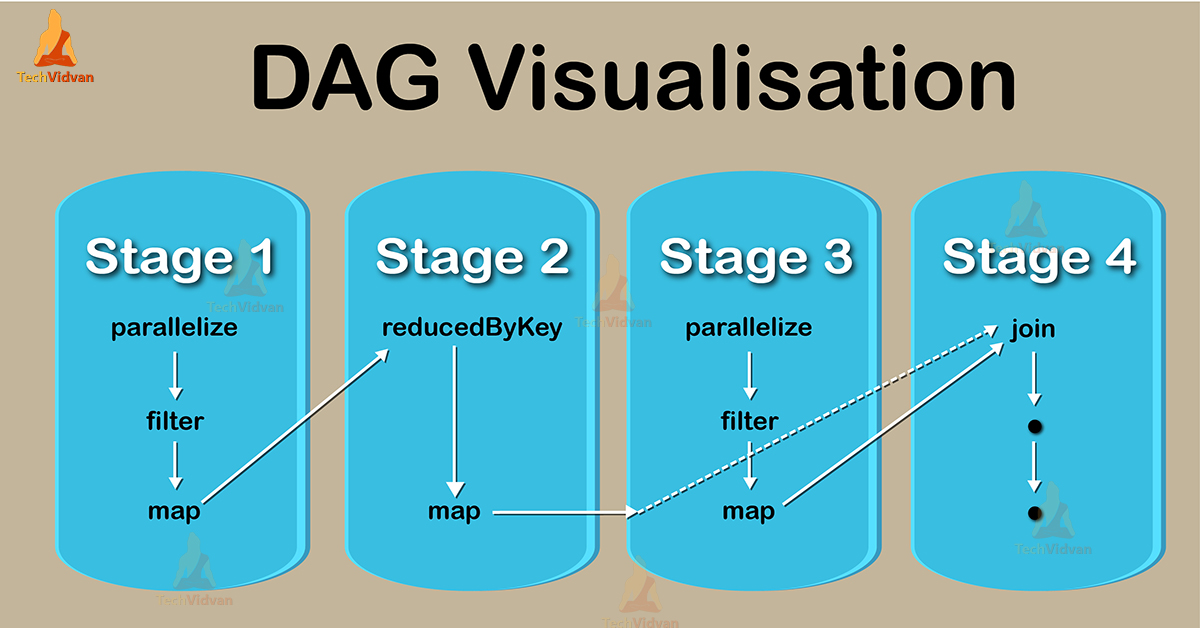

In [2]:
# 'parallelize' creates an RDD by distributing data over the cluster
rdd = sc.parallelize(range(14), numSlices=4)
print("Number of partitions: {}".format(rdd.getNumPartitions()))
# 'glom' lists all elements within each partition
print(rdd.glom().collect())

Number of partitions: 4
[[0, 1, 2], [3, 4, 5, 6], [7, 8, 9], [10, 11, 12, 13]]


In [17]:
rddSquared = rdd.map(lambda x: x ** 2)

# The 'collect' action triggers Spark: the above transformation is performed,
# and results are collected.
print(rddSquared.collect())

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169]


In [3]:
rdd

PythonRDD[2] at RDD at PythonRDD.scala:53

In [32]:
# Actions with which to take data from an RDD:
print(rdd.collect())                    # get all elements
print(rdd.first())                      # get first element
print(rdd.take(5))                      # get N first elements
print(rdd.top(3))                       # get N highest elements in descending order
print(rdd.takeOrdered(7, lambda x: -x)) # get N first elements in ascending (or a function's) order

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
0
[0, 1, 2, 3, 4]
[13, 12, 11]
[13, 12, 11, 10, 9, 8, 7]


In [33]:
# RDDs support simple statistical actions¶
print(rdd.stats())
print(rdd.count())
print(rdd.sum())
print(rdd.mean())
print(rdd.stdev(), rdd.sampleStdev())
print(rdd.variance(), rdd.sampleVariance())
print(rdd.min(), rdd.max())
print(rdd.histogram(5))

(count: 14, mean: 6.5, stdev: 4.031128874149275, max: 13.0, min: 0.0)
14
91
6.5
4.031128874149275 4.183300132670378
16.25 17.5
0 13
([0.0, 2.6, 5.2, 7.800000000000001, 10.4, 13], [3, 3, 2, 3, 3])


In [41]:
data = [1,2,3,4,5]
rdd = sc.parallelize(data)
mapRdd = rdd.map(lambda x:x*2)
filterRdd = mapRdd.filter(lambda x:x > 5)
print(filterRdd.collect())

[6, 8, 10]


In [40]:
data = ["hello spark", "hello world", "hello world"]
rdd = sc.parallelize(data)
mapRdd = rdd.flatMap(lambda line: line.split(" "))
print(mapRdd.take(10))

['hello', 'spark', 'hello', 'world', 'hello', 'world']


In [43]:
data = ["hello spark", "hello world", "hello world"]
rdd = sc.parallelize(data)
mapRdd = rdd.flatMap(lambda line: line.split(" ")).map(lambda x: (x, 1))
print(mapRdd.collect())
reduceByKeyRdd = mapRdd.reduceByKey(lambda a,b:a+b)
print(reduceByKeyRdd.collect())

[('hello', 1), ('spark', 1), ('hello', 1), ('world', 1), ('hello', 1), ('world', 1)]
[('hello', 3), ('spark', 1), ('world', 2)]


In [45]:
a = sc.parallelize([1,2,3])
b = sc.parallelize([3,4,5])
U = a.union(b).collect()
print(U)

[1, 2, 3, 3, 4, 5]


In [46]:
a = sc.parallelize([1, 2, 3])
b = sc.parallelize([3, 4, 2])
D = a.union(b).distinct().collect()
print(D)

[1, 2, 3, 4]


### 创建 DataFrames

在一个 SparkSession中, 应用程序可以从一个 已经存在的 RDD 或者 hive表, 或者从Spark数据源中创建一个DataFrames.

举个例子, 下面就是基于一个JSON文件创建一个DataFrame:

In [4]:
!cat people.json

{"name":"Michael"}
{"name":"Andy", "age":30}
{"name":"Justin", "age":19}


In [3]:
import os
df = spark.read.json("file:///%s/people.json" % os.getcwd())

In [4]:
df.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



### DataFrame 操作

DataFrames 提供了一个特定的语法用在 Scala, Java, Python and R中机构化数据的操作。

在Python中，可以通过(df.age) 或者(df['age'])来获取DataFrame的列. 虽然前者便于交互式操作, 但是还是建议用户使用后者, 这样不会破坏列名，也能引用DataFrame的类。

### 注意以下操作的select

In [5]:
df.printSchema()
# 表格具体的格式、列名、是不是缺失

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



In [6]:
df.select("name").show()

+-------+
|   name|
+-------+
|Michael|
|   Andy|
| Justin|
+-------+



In [7]:
df.select(["name",'age']).show()

+-------+----+
|   name| age|
+-------+----+
|Michael|null|
|   Andy|  30|
| Justin|  19|
+-------+----+



In [8]:
df.select(df['name'], df['age'] + 1).show()

+-------+---------+
|   name|(age + 1)|
+-------+---------+
|Michael|     null|
|   Andy|       31|
| Justin|       20|
+-------+---------+



### 以下操作的filter做数据选择

In [9]:
df.filter(df['age'] > 21).show()

+---+----+
|age|name|
+---+----+
| 30|Andy|
+---+----+



In [10]:
df.groupBy("age").count().show()

+----+-----+
| age|count|
+----+-----+
|  19|    1|
|null|    1|
|  30|    1|
+----+-----+



**更多的资料请查阅pandas DataFrame cheatsheet**

### spark SQL

SparkSession 的 sql 函数可以让应用程序以编程的方式运行 SQL 查询, 并将结果作为一个 DataFrame 返回.

In [11]:
df.createOrReplaceTempView("people")

sqlDF = spark.sql("SELECT * FROM people")
sqlDF.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



### spark DataFrame与RDD交互
Spark SQL 支持两种不同的方法用于转换已存在的 RDD 成为 Dataset

第一种方法是使用反射去推断一个包含指定的对象类型的 RDD 的 Schema.在你的 Spark 应用程序中当你已知 Schema 时这个基于方法的反射可以让你的代码更简洁.

第二种用于创建 Dataset 的方法是通过一个允许你构造一个 Schema 然后把它应用到一个已存在的 RDD 的编程接口.然而这种方法更繁琐, 当列和它们的类型知道运行时都是未知时它允许你去构造 Dataset.

#### 反射推断

In [5]:
! cat people.txt

Michael, 29
Andy, 30
Justin, 19


In [3]:
from pyspark.sql import Row

sc = spark.sparkContext
lines = sc.textFile("file:///%s/people.txt" % os.getcwd())
parts = lines.map(lambda l: l.split(","))
people = parts.map(lambda p: Row(name=p[0], age=int(p[1])))

# Infer the schema, and register the DataFrame as a table.
schemaPeople = spark.createDataFrame(people)
schemaPeople.createOrReplaceTempView("people")

In [4]:
teenagers = spark.sql("SELECT name FROM people WHERE age >= 13 AND age <= 19")

In [5]:
type(teenagers)

pyspark.sql.dataframe.DataFrame

In [6]:
type(teenagers.rdd)

pyspark.rdd.RDD

In [7]:
teenagers.rdd.first()

Row(name='Justin')

In [8]:
teenNames = teenagers.rdd.map(lambda p: "Name: " + p.name).collect()
for name in teenNames:
    print(name)

Name: Justin


#### 以编程的方式指定Schema

也可以通过以下的方式去初始化一个 DataFrame。

* RDD从原始的RDD穿件一个RDD的toples或者一个列表;
* Step 1 被创建后, 创建 Schema 表示一个 StructType 匹配 RDD 中的结构.
* 通过 SparkSession 提供的 createDataFrame 方法应用 Schema 到 RDD .

In [9]:
from pyspark.sql.types import *

sc = spark.sparkContext

# Load a text file and convert each line to a Row.
lines = sc.textFile("file:///%s/people.txt" % os.getcwd())
parts = lines.map(lambda l: l.split(","))
# Each line is converted to a tuple.
people = parts.map(lambda p: (p[0], p[1].strip()))

# The schema is encoded in a string.
schemaString = "name age"

fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)

# Apply the schema to the RDD.
schemaPeople = spark.createDataFrame(people, schema)

In [10]:
schemaPeople.createOrReplaceTempView("people")
results = spark.sql("SELECT name FROM people")
results.show()

+-------+
|   name|
+-------+
|Michael|
|   Andy|
| Justin|
+-------+

